## Project Template

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from delta import *
from delta.tables import *
from datetime import datetime
import os
import matplotlib.pyplot as plt
import pandas as pd

builder = SparkSession.builder.appName("Streaming2_practice") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.streaming.statefulOperator.checkCorrectness.enabled", "false") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.adaptive.enabled", "false") \
    .config("spark.sql.debug.maxToStringFields", "10000")

spark = configure_spark_with_delta_pip(builder).getOrCreate() # type: ignore


In [3]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType

schema = StructType(
      [
        StructField("hack_license", StringType(), False),
        StructField("pick_up_location", StringType(), False),
        StructField("drop_off_location", StringType(), False),
        StructField("pick_up_time", TimestampType(), False),
        StructField("drop_off_time", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )

In [4]:
brokers = os.getenv('KAFKA_ADVERTISED_LISTENERS')
protocol = os.getenv('KAFKA_LISTENER_SECURITY_PROTOCOL_MAP') 

lines = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", brokers)
    .option("kafka.security.protocol", protocol)
    .option("subscribe", "stock")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
)

df = lines.select(F.from_json(lines.value.cast("string"), schema).alias("data")).select("data.*")
df.writeStream.format("console").start().awaitTermination(5)


False

## [Query 1] Utilization over a window of 5, 10, and 15 minutes per taxi/driver. This can be computed by computing the idle time per taxi. How does it change? Is there an optimal window?

In [5]:

checkpoint_path = "./checkpoint" 
output_path = "./output"
# in order not to skip much data, we set the watermark duration to 2 hours
watermark_duration = "2 hours"
# we set the slide duration to 1 minute to have real-time updates per window
slide_duration = "1 minute"


# Set up queries for each window duration
queries = []
windows = [5, 10, 15]
for duration in windows:
    idle_table = f"idle_time_{duration}"
    window_duration = f"{duration} minutes"

    # Define watermarks on the timestamp field used for windowing
    df_stream_current = df.withWatermark("drop_off_time", watermark_duration)
    df_stream_next = df.withWatermark("pick_up_time", watermark_duration)

    # Join using conditions that include a time range based on watermarks
    join_condition = [
        F.col("current.hack_license") == F.col("next.hack_license"),
        F.col("current.drop_off_time") < F.col("next.pick_up_time"),
        F.col("next.pick_up_time") <= F.col("current.drop_off_time") + F.expr("interval 24 hours")
    ]

    df_next_trip = df_stream_current.alias("current").join(
        df_stream_next.alias("next"),
        on=join_condition,
        how="left_outer"
    ).select(
        F.col("current.hack_license"),
        F.col("current.drop_off_time"),
        F.col("next.pick_up_time"),
        F.expr("unix_timestamp(next.pick_up_time) - unix_timestamp(current.drop_off_time)").alias("idle_time")
    )
   

    # Calculate total idle time per taxi
    idle_time_per_taxi = df_next_trip.groupBy(
        F.window(F.col("drop_off_time"), window_duration, slide_duration),
        F.col("hack_license")
    ).agg(
        F.sum("idle_time").alias("total_idle_time")
    )

    # Filter out negative idle times (if any)
    idle_time_filtered = idle_time_per_taxi.filter(F.col("total_idle_time") > 0)

    # Write the stream to a Delta table
    query = idle_time_filtered.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/{idle_table}") \
    .option("path", f"{output_path}/{idle_table}") \
    .option("mergeSchema", "true") \
    .start()

In [6]:
def read_delta_table(path):
    return spark.read.format("delta").load(path);

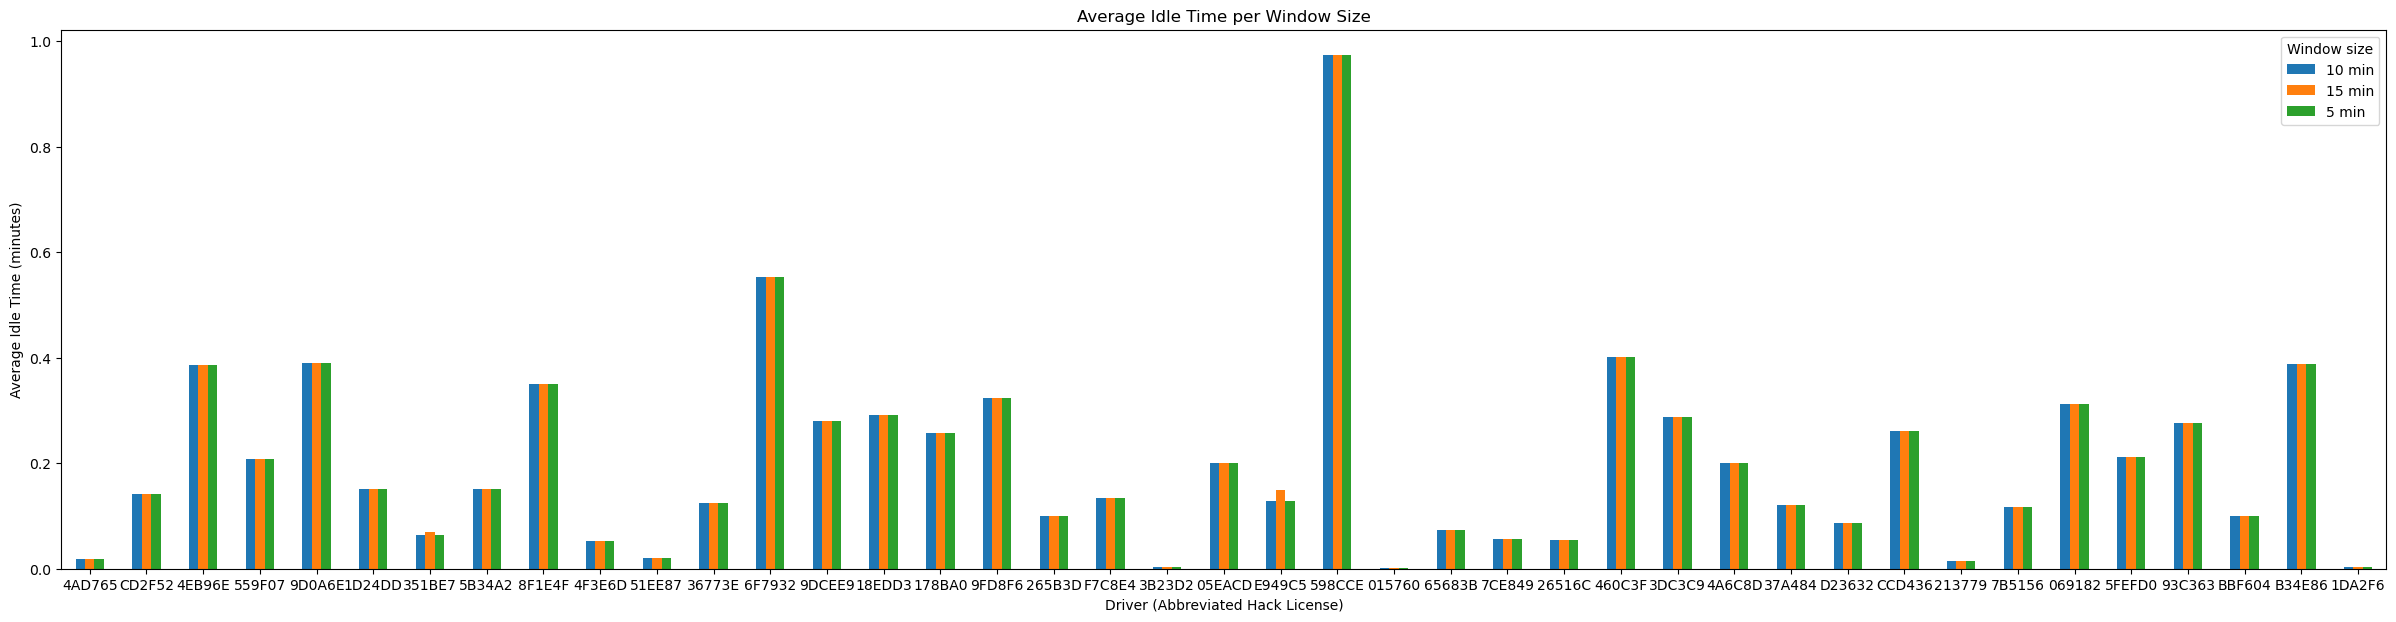

In [7]:
# Collect data from different window outputs
data_frames = {duration: read_delta_table(f"{output_path}/idle_time_{duration}") for duration in windows}
for duration, local_df in data_frames.items():
    local_df = local_df.withColumn('window_size', F.lit(f"{duration} min"))
    data_frames[duration] = local_df

# Combine all data frames into one
combined_df = data_frames[windows[0]]
for duration in windows[1:]:
    combined_df = combined_df.union(data_frames[duration])

# Drop the 'window' column
combined_df = combined_df.drop('window')

# Abbreviate the hack license to the first 6 characters for better readability
combined_df = combined_df.withColumn('hack_license', F.substring('hack_license', 1, 6))

# Convert total_idle_time from ms to minutes
combined_df = combined_df.withColumn('total_idle_time', F.col('total_idle_time') / 60000)

# Pivot the DataFrame
pivot_df = combined_df.groupBy('hack_license').pivot('window_size').avg('total_idle_time')

# Convert to Pandas for plotting
pivot_pd_df = pivot_df.toPandas()

# Plotting
pivot_pd_df.set_index('hack_license').plot(kind='bar', figsize=(30, 7))
plt.title('Average Idle Time per Window Size')
plt.xlabel('Driver (Abbreviated Hack License)')
plt.ylabel('Average Idle Time (minutes)')
plt.xticks(rotation=0)
plt.legend(title='Window size')
plt.show()

The chart shows the average idle time for each taxi across three different window sizes (5, 10, and 15 minutes), revealing that idle times are generally consistent across window sizes for most taxis. However, some taxis show noticeable differences, with larger window sizes sometimes leading to higher idle times. While the chart does not indicate a universally optimal window size, the 5-minute window tends to show slightly lower idle times, which might be preferable for identifying shorter idle periods. For most use cases, a 10-minute window size offers a good balance between granularity and efficiency. 

## [Query 2] The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up within a given unit of time

In [9]:
next_fare_table = "next_fare"

# Define watermarks on the timestamp field used for windowing
# Apply watermarks to both DataFrames on the timestamp fields
df_stream_current = df.withWatermark("drop_off_time", watermark_duration)
df_stream_next = df.withWatermark("pick_up_time", watermark_duration)

# Join using conditions that include a time range based on watermarks
join_condition = [
    F.col("current.hack_license") == F.col("next.hack_license"),
    F.col("current.drop_off_time") < F.col("next.pick_up_time"),
    F.col("next.pick_up_time") <= F.col("current.drop_off_time") + F.expr("interval 24 hours") #boundary condition
]


df_next_trip = df_stream_current.alias("current").join(
    df_stream_next.alias("next"),
    on=join_condition,
    how="left_outer"
).select(
    F.col("current.drop_off_location").alias("drop_off_borough"),
    F.col("current.drop_off_time"),
    F.col("next.pick_up_time").alias("next_pick_up_time"),
    F.expr("unix_timestamp(next_pick_up_time) - unix_timestamp(current.drop_off_time)").alias("time_to_next_fare")
)

# Define a window for aggregation
window_duration = "1 hour"
slide_duration = "1 minute"


# Calculate average time to the next fare per borough
avg_time_to_next_fare = df_next_trip.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_borough")
).agg(
    F.avg("time_to_next_fare").alias("avg_time_to_next_fare")
)
avg_time_to_next_fare_filtered = avg_time_to_next_fare.filter(F.col("avg_time_to_next_fare") > 0).filter(F.expr("drop_off_borough is not null"))


query = avg_time_to_next_fare_filtered.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="120 seconds") \
    .option("checkpointLocation", f"{checkpoint_path}/{next_fare_table}") \
    .option("path", f"{output_path}/{next_fare_table}") \
    .option("mergeSchema", "true") \
    .start()

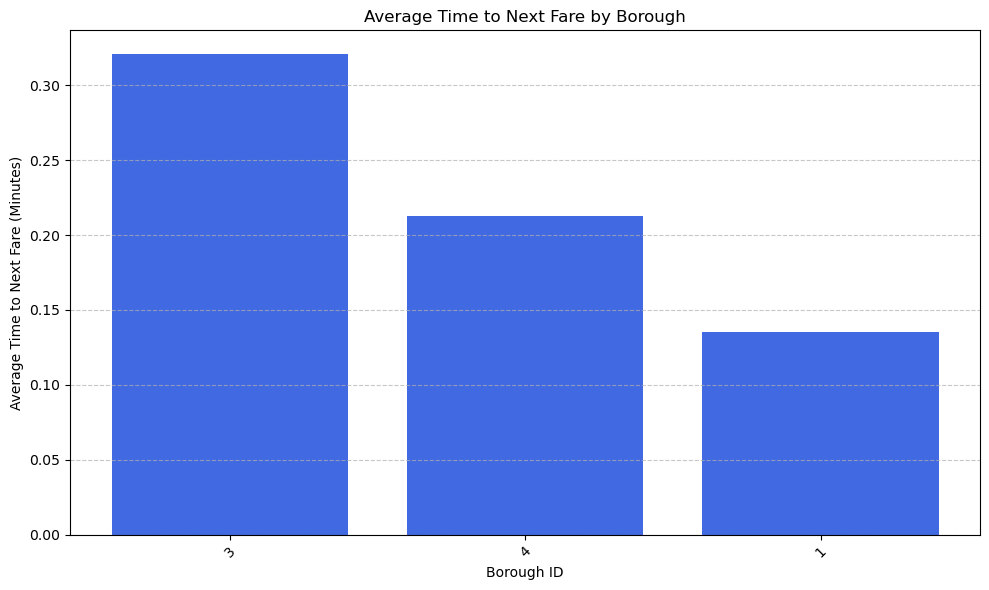

In [10]:
df_fares = read_delta_table(f"{output_path}/{next_fare_table}")

# Convert 'window' column to start and end timestamps
df_fares = df_fares.withColumn('window_start', F.to_timestamp(F.col('window.start'))) \
                   .withColumn('window_end', F.to_timestamp(F.col('window.end')))

# Drop rows where 'avg_time_to_next_fare' is null
df_fares = df_fares.dropna(subset=['avg_time_to_next_fare'])

# Calculate the overall average time to the next fare per borough
borough_avg_time = df_fares.groupBy('drop_off_borough') \
                           .agg(F.mean('avg_time_to_next_fare').alias('avg_time_to_next_fare'))

# Convert total_idle_time from ms to minutes
borough_avg_time = borough_avg_time.withColumn('avg_time_to_next_fare', F.col('avg_time_to_next_fare') / 60000)

# Convert to Pandas DataFrame for plotting
pd_borough_avg_time = borough_avg_time.orderBy(F.col('avg_time_to_next_fare').desc()).toPandas()


plt.figure(figsize=(10, 6))
plt.bar(pd_borough_avg_time['drop_off_borough'].astype(str), pd_borough_avg_time['avg_time_to_next_fare'], color='royalblue')

plt.xlabel('Borough ID')
plt.ylabel('Average Time to Next Fare (Minutes)')
plt.title('Average Time to Next Fare by Borough')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better alignment

plt.tight_layout()
plt.show()

## [Query 3] The number of trips that started and ended within the same borough in the last hour

In [11]:
same_borough_table = "same_borough"

# As we want to know for last hour
df_stream = df.withWatermark("drop_off_time", "1 hour")
same_borough_trips = df_stream.filter(
    F.col("pick_up_location") == F.col("drop_off_location")
)
# As we want to know for last hour
window_duration = "1 hour"
slide_duration = "1 minute"


trips_per_same_borough_per_hour = same_borough_trips.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_location")
).count().withColumnRenamed("count", "number_of_trips")

query = trips_per_same_borough_per_hour.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="1 minute") \
    .option("checkpointLocation", f"{checkpoint_path}/{same_borough_table}") \
    .option("path", f"{output_path}/{same_borough_table}") \
    .option("mergeSchema", "true") \
    .start()

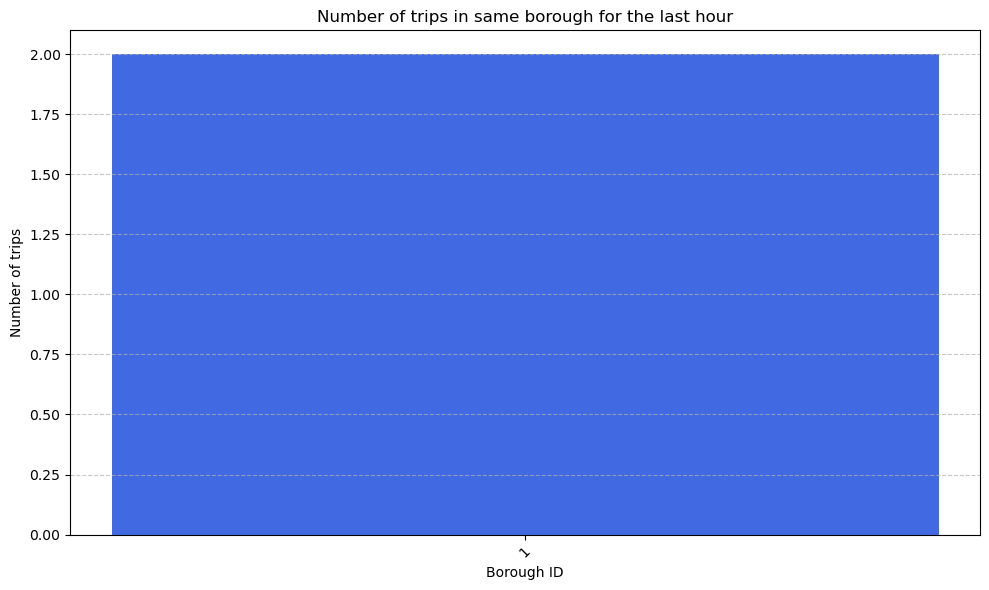

In [12]:
df_same_fares = read_delta_table(f"{output_path}/{same_borough_table}")

# Get max timestamp
max_timestamp = df_same_fares.agg(F.max("window.end")).collect()[0][0]
# Filter data for the last hour from dataset end
last_hour_data = df_same_fares.filter(F.col("window.end") > F.expr(f"timestamp('{max_timestamp}') - interval 1 hour"))
# Convert to Pandas for plotting
last_hour_pd = last_hour_data.select("drop_off_location", "number_of_trips").toPandas()

# Plotting the number of trips for the last hour
plt.figure(figsize=(10, 6))
plt.bar(last_hour_pd['drop_off_location'].astype(str), last_hour_pd['number_of_trips'], color='royalblue')

plt.xlabel('Borough ID')
plt.ylabel('Number of trips')
plt.title('Number of trips in same borough for the last hour')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better alignment

plt.tight_layout()
plt.show()

## [Query 4] The number of trips that started in one borough and ended in another one in the last hour

In [13]:
different_borough_table = "different_borough"

# As we want to know for last hour
df_stream = df.withWatermark("drop_off_time", "1 hour")
diff_borough_trips = df_stream.filter(
    F.col("pick_up_location") != F.col("drop_off_location")
)
# As we want to know for the 1 hour
window_duration = "1 hour"
slide_duration = "1 minute"

trips_per_diff_borough_per_hour = diff_borough_trips.groupBy(
    F.window(F.col("drop_off_time"), window_duration, slide_duration),
    F.col("drop_off_location")
).count().withColumnRenamed("count", "number_of_trips")

query = trips_per_diff_borough_per_hour.writeStream \
    .outputMode("append") \
    .format("delta") \
    .trigger(processingTime="1 minute") \
    .option("checkpointLocation", f"{checkpoint_path}/{different_borough_table}") \
    .option("path", f"{output_path}/{different_borough_table}") \
    .option("mergeSchema", "true") \
    .start()

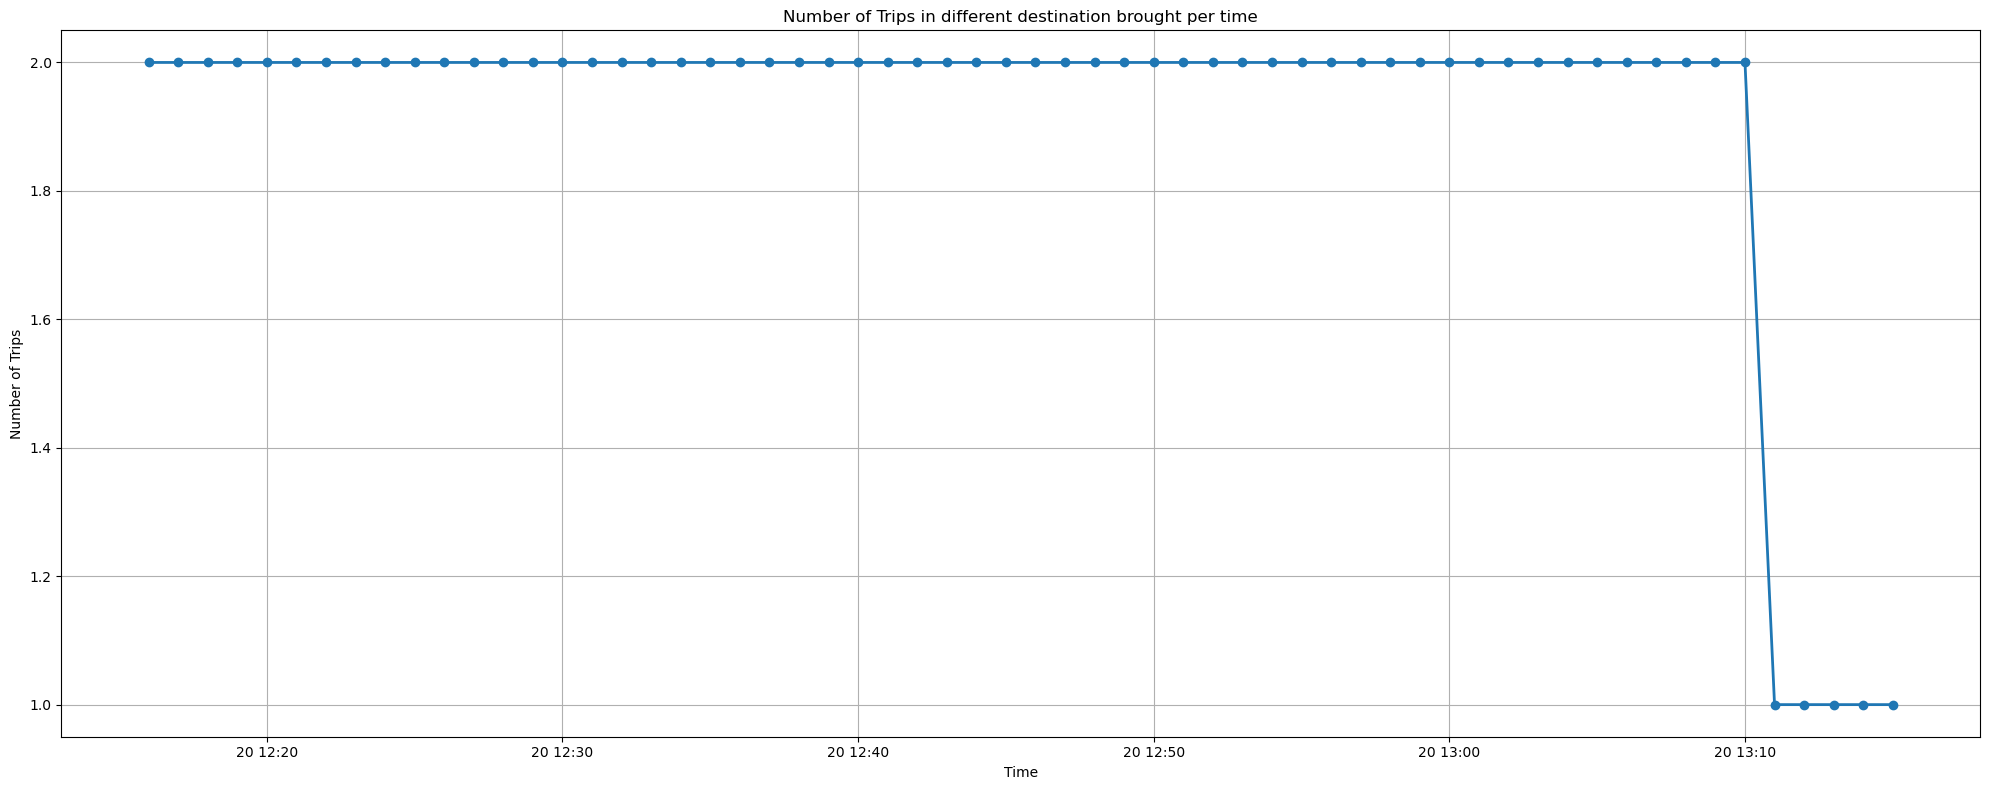

In [14]:
df_diff_fares = read_delta_table(f"{output_path}/{different_borough_table}")

# Get max timestamp
diff_max_timestamp = df_diff_fares.agg(F.max("window.end")).collect()[0][0]

# Filter data for the last hour from dataset end
diff_last_hour_data = df_diff_fares.filter(F.col("window.end") > F.expr(f"timestamp('{diff_max_timestamp}') - interval 1 hour")).sort("window.end");

diff_last_hour_pd = last_hour_data.select("window", "number_of_trips").toPandas()
diff_last_hour_pd['window_end'] = diff_last_hour_pd['window'].apply(lambda x: x['end'])
diff_last_hour_pd = diff_last_hour_pd.sort_values('window_end')


# Plot the number of trips per hour as a smoothed line chart
plt.figure(figsize=(20, 8))
plt.plot(diff_last_hour_pd['window_end'], diff_last_hour_pd['number_of_trips'], marker='o', linestyle='-', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Number of Trips in different destination brought per time')
plt.grid(True)
plt.tight_layout()

plt.show()
